In [69]:
import os

os.chdir('/home/yry08/yigedabuliu/lkq/LiteMedSAM')

In [70]:
import random
import monai
from os import listdir, makedirs
from os.path import join, exists, isfile, isdir, basename
from glob import glob
from tqdm import tqdm, trange
from copy import deepcopy
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

from segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer
from tiny_vit_sam import TinyViT
import cv2
import torch.nn.functional as F

import argparse

In [71]:
npy_path = '/mnt/sda3/yigedabuliu/lkq/data/Task01_BrainTumour/npy/'

In [72]:
class NpyDataset(Dataset):
    def __init__(self, data_root, image_size=256, data_aug=True):
        self.data_root = data_root
        self.gt_path = join(data_root, 'gts')
        self.img_path = join(data_root, 'imgs')
        self.gt_path_files = sorted(glob(join(self.gt_path, '*.npy'), recursive=True))
        self.gt_path_files = [
            file for file in self.gt_path_files
            if isfile(join(self.img_path, basename(file)))
        ]
        self.image_size = image_size
        self.data_aug = data_aug

    def __len__(self):
        return len(self.gt_path_files)

    def __getitem__(self, index):
        file_name = basename(self.gt_path_files[index])
        assert file_name == basename(self.gt_path_files[index]), 'img gt name error' + self.gt_path_files[index] + \
                                                                 self.npy_files[index]
        img_3c = np.load(join(self.img_path, file_name), 'r', allow_pickle=True)  # (H, W, 3)
        img_3c = self.pad_image(img_3c)

        label = np.load(join(self.gt_path, file_name), 'r', allow_pickle=True)
        # print(f'label shape:{label.shape}')
        label = self.pad_gt2D(label)
        # print(f'file_name:{file_name}')

        rows, cols = np.where(label[0] == 1)

        # 找到边界
        top = np.min(rows)
        bottom = np.max(rows)
        left = np.min(cols)
        right = np.max(cols)

        boxes = np.array([[[left, top, right, bottom]]])

        return {
            "image": torch.tensor(np.transpose(img_3c, (2, 0, 1))),
            "gt2D": torch.tensor(label),
            "bboxes": torch.tensor(boxes)
        }

    def pad_image(self, image):
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        # Pad
        h, w = image.shape[0], image.shape[1]
        padh = self.image_size - h
        padw = self.image_size - w
        if len(image.shape) == 3:  ## Pad image
            image_padded = np.pad(image, ((0, padh), (0, padw), (0, 0)))
        else:  ## Pad gt mask
            image_padded = np.pad(image, ((0, padh), (0, padw)))

        return image_padded

    def pad_gt2D(self, gt2D):
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        # Pad
        h, w = gt2D.shape[1], gt2D.shape[2]
        padh = self.image_size - h
        padw = self.image_size - w
        if len(gt2D.shape) == 3:  ## Pad image
            gt2D_padded = np.pad(gt2D, ((0, 0), (0, padh), (0, padw)))
        else:  ## Pad gt mask
            gt2D_padded = np.pad(gt2D, ((0, padh), (0, padw)))

        return gt2D_padded

In [73]:
train_dataset = NpyDataset(data_root=npy_path, data_aug=True)
batch_size = 2
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
data = train_loader.dataset[2]

In [74]:
# 读取后的可视化测试
image = data['image']
gt2D = data["gt2D"]
boxes = data["bboxes"]

print(f'image shape:{image.shape}')
print(f'gt2D shape:{gt2D.shape}')
print(f'boxes shape:{boxes.shape}')

image shape:torch.Size([3, 256, 256])
gt2D shape:torch.Size([1, 256, 256])
boxes shape:torch.Size([1, 1, 4])


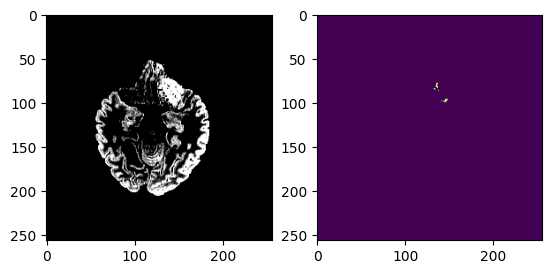

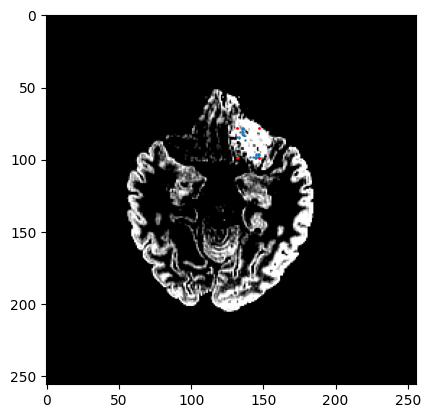

In [75]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image.permute(1, 2, 0))
axes[1].imshow(gt2D.permute(1, 2, 0))
plt.show()

# 同时显示

new_gt = gt2D[0]
indices = torch.nonzero(new_gt)

plt.imshow(image.permute(1, 2, 0))
plt.scatter(x=indices[:, 1], y=indices[:, 0], s=0.5)
# 画box

x1y1 = (boxes[0][0][0], boxes[0][0][1])
x2y2 = (boxes[0][0][2], boxes[0][0][3])

plt.scatter(x1y1[0], x1y1[1], s=1, c='r')  # 左上
plt.scatter(x2y2[0], x1y1[1], s=1, c='r')  # 右上
plt.scatter(x1y1[0], x2y2[1], s=1, c='r')  # 左下
plt.scatter(x2y2[0], x2y2[1], s=1, c='r')  # 右下

plt.show()

In [76]:
# 搭建LiteMedSAM进行测试

class MedSAM_Lite(nn.Module):
    def __init__(self,
                 image_encoder,
                 mask_decoder,
                 prompt_encoder
                 ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

    def forward(self, image, boxes):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)

        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None,
            boxes=boxes,
            masks=None,
        )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )  # (B, 1, 256, 256)

        return low_res_masks, iou_predictions

    @torch.no_grad()
    def postprocess_masks(self, masks, new_size, original_size):
        """
        Do cropping and resizing
        """
        # Crop
        masks = masks[:, :, :new_size[0], :new_size[1]]
        # Resize
        masks = F.interpolate(
            masks,
            size=(original_size[0], original_size[1]),
            mode="bilinear",
            align_corners=False,
        )

        return masks


medsam_lite_image_encoder = TinyViT(
    img_size=256,
    in_chans=3,
    embed_dims=[
        64,  ## (64, 256, 256)
        128,  ## (128, 128, 128)
        160,  ## (160, 64, 64)
        320  ## (320, 64, 64)
    ],
    depths=[2, 2, 6, 2],
    num_heads=[2, 4, 5, 10],
    window_sizes=[7, 7, 14, 7],
    mlp_ratio=4.,
    drop_rate=0.,
    drop_path_rate=0.0,
    use_checkpoint=False,
    mbconv_expand_ratio=4.0,
    local_conv_size=3,
    layer_lr_decay=0.8
)

medsam_lite_prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(256, 256),
    mask_in_chans=16
)

medsam_lite_mask_decoder = MaskDecoder(
    num_multimask_outputs=3,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8,
    ),
    transformer_dim=256,
    iou_head_depth=3,
    iou_head_hidden_dim=256,
)

medsam_lite_model = MedSAM_Lite(
    image_encoder=medsam_lite_image_encoder,
    mask_decoder=medsam_lite_mask_decoder,
    prompt_encoder=medsam_lite_prompt_encoder
)

In [77]:
# 为数据增加批次维度

batch_iamge = image.unsqueeze(dim=0)
batch_boxes = boxes.unsqueeze(dim=0)
print(f'batch image and box shape:{batch_iamge.shape},{batch_boxes.shape}')

medsam_lite_checkpoint_path = '/mnt/sda3/yigedabuliu/lkq/LiteMedSAM/work_dir/LiteMedSAM/lite_medsam.pth'
medsam_lite_checkpoint = torch.load(medsam_lite_checkpoint_path, map_location='cpu')
medsam_lite_model.load_state_dict(medsam_lite_checkpoint)
# medsam_lite_model.to(device)
medsam_lite_model.eval()


batch image and box shape:torch.Size([1, 3, 256, 256]),torch.Size([1, 1, 1, 4])


MedSAM_Lite(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
              (c): Conv2d

In [78]:
def medsam_inference(medsam_model, img_embed, box_256, new_size, original_size):
    box_torch = torch.as_tensor(box_256, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False
    )

    low_res_pred = medsam_model.postprocess_masks(low_res_logits, new_size, original_size)
    low_res_pred = torch.sigmoid(low_res_pred)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)

    return medsam_seg

In [79]:
image_embedding = medsam_lite_model.image_encoder(batch_iamge)
sam_mask = medsam_inference(medsam_lite_model, image_embedding, batch_boxes, (256, 256), (256, 256))



In [80]:
sam_mask.shape

(256, 256)

In [81]:
sam_mask = torch.tensor(sam_mask)
indices = torch.nonzero(sam_mask)

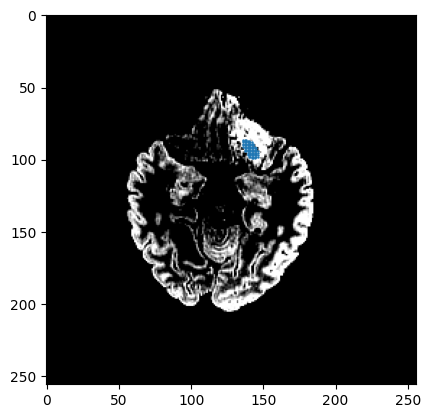

In [82]:
# plt.imshow(sam_mask,alpha=0.5)
plt.imshow(image.permute(1, 2, 0), alpha=1)
plt.scatter(indices[:, 1], indices[:, 0], s=0.5)

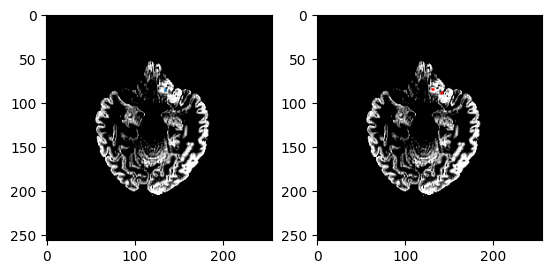

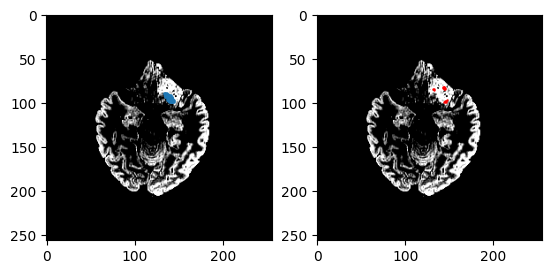

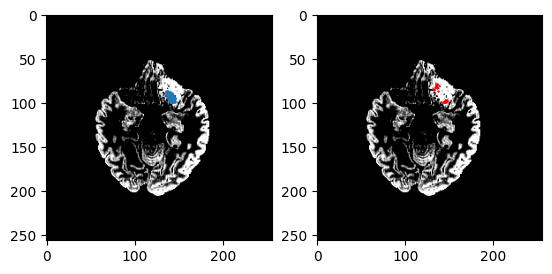

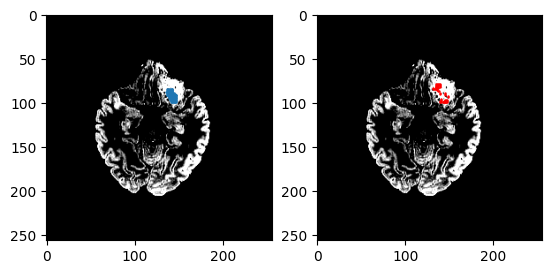

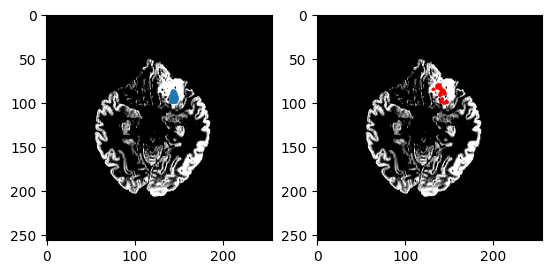

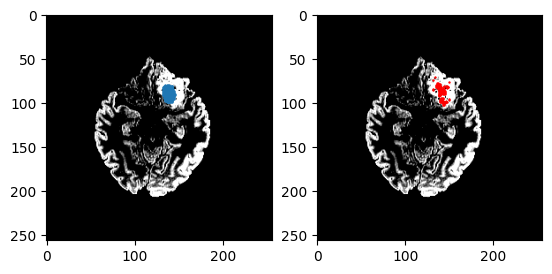

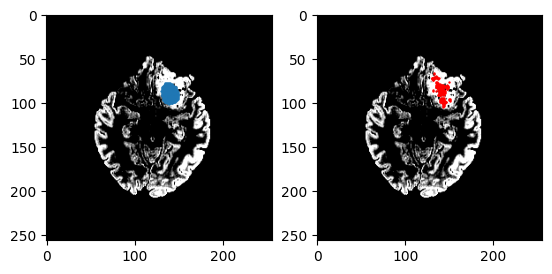

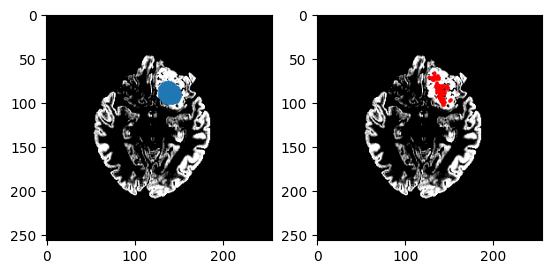

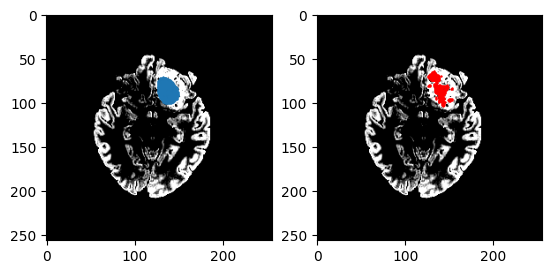

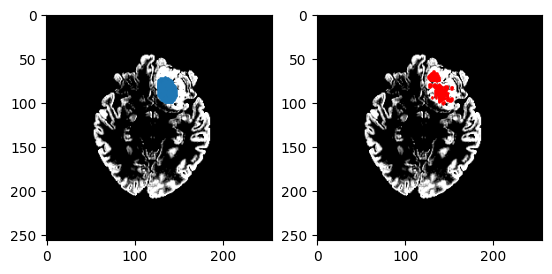

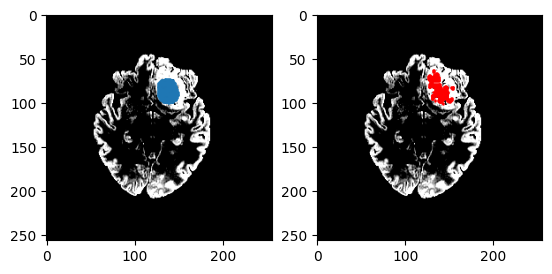

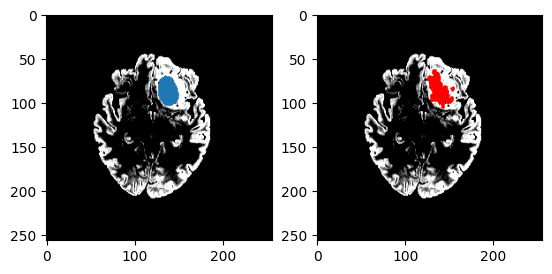

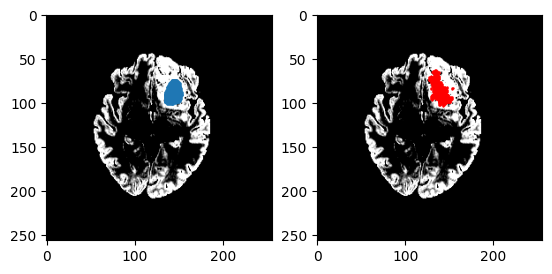

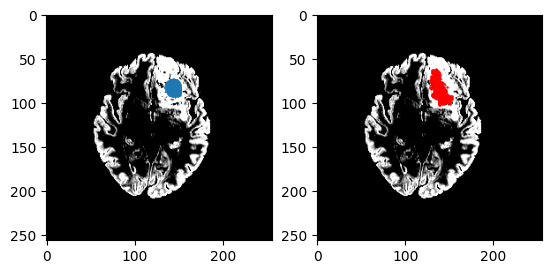

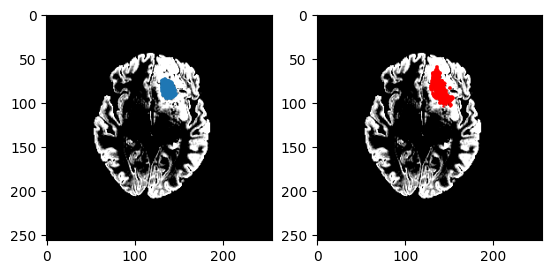

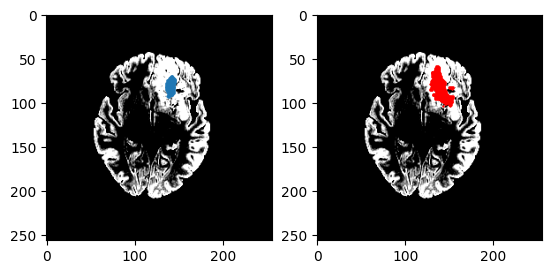

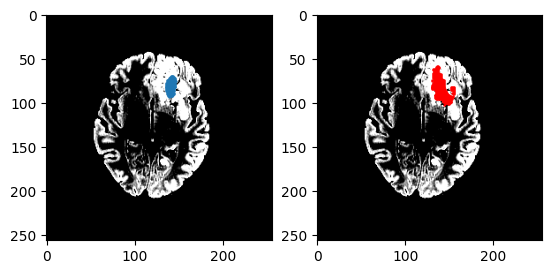

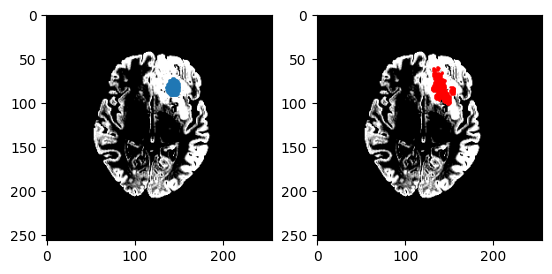

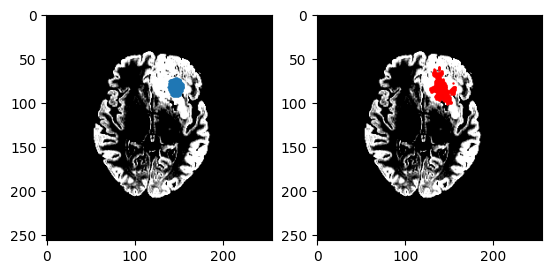

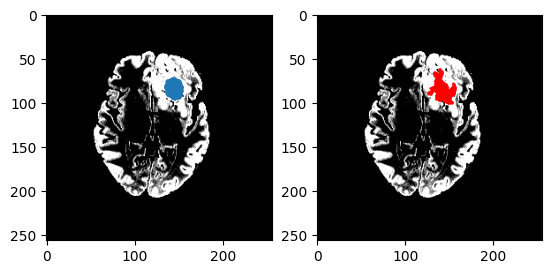

In [83]:

# 循环可视化预测与真值

train_dataset = NpyDataset(data_root=npy_path, data_aug=True)
batch_size = 2
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

for i in range(20):
    data = train_loader.dataset[i]

    image = data['image']
    gt2D = data["gt2D"]
    boxes = data["bboxes"]

    batch_iamge = image.unsqueeze(dim=0)
    batch_boxes = boxes.unsqueeze(dim=0)

    # batch_boxes = torch.tensor([[[[50, 50, 155, 155]]]])

    image_embedding = medsam_lite_model.image_encoder(batch_iamge)
    sam_mask = medsam_inference(medsam_lite_model, image_embedding, batch_boxes, (256, 256), (256, 256))

    sam_mask = torch.tensor(sam_mask)
    indices = torch.nonzero(sam_mask)

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].scatter(indices[:, 1], indices[:, 0], s=0.5)

    axes[1].imshow(image.permute(1, 2, 0))
    new_gt = gt2D[0]
    indices = torch.nonzero(new_gt)

    axes[1].scatter(x=indices[:, 1], y=indices[:, 0], s=0.5, c='r')

    plt.show()




In [84]:
batch_boxes

tensor([[[[126,  61, 157, 100]]]])

In [85]:
batch_boxes.shape

torch.Size([1, 1, 1, 4])